# The Price Is Right: Predicting Prices with Product Images

### Milestone Report

------------

**Steven Chen, Edward Chou, Richard Yang**

(Edward Chou and Richard Yang are not part of 230, but are part of 229.)



## Loading Packages

---------------

For this project, we choose to use Keras with a Tensorflow backend. Keras is well suited for building complex CNNs, and we have experience with both Tensorflow and Keras from the CS230 programming assignments.

In [1]:
import csv
import math

import matplotlib.pyplot as plt
import numpy as np

from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.initializers import glorot_uniform

from keras.applications.vgg16 import preprocess_input

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


We initialize the VGG-16 network without the final (top) layer, using the learned ImageNet weights. VGG-16 is a very deep CNN trained for object recognition on the ImageNet challenge.

In [2]:
# hyperparameters

hp_dropout = 0.2

#RMSprop
hp_lr = 0.01
hp_rho = 0.9 #RMSprop
hp_epsilon = 1e-07
hp_decay = 0.0

# Number of hidden units
hp_hidden = 256

# Minibatch size
hp_mbsize = 64

In [3]:
# build the VGG16 network
input_tensor = Input(shape=(224,224,3))
model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

We build our own layer on top of VGG. In particular, we flatten the final feature mapping of VGG-16 (consisting of 512 7 by 7 filters) into a single dimension. We then add a fully connected layer of 256 hidden units with ReLU activations, and use uniform Xavier initialization.

We finish our model with an output layer of a single linear activation neuron, which will output the predicted price.

In [4]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=(model.output_shape[1:])))


# Output layer
# We do random weight intialization
top_model.add(Dropout(hp_dropout))
top_model.add(Dense(hp_hidden, activation='relu', kernel_initializer='glorot_uniform'))
top_model.add(Dense(1, activation='linear', name='output', kernel_initializer='glorot_uniform'))

We set the pretrained VGG layers to be non-trainable so that we do spend time learning them. Instead, our learning will focus on the new layers we have added.

In [5]:
# add the model on top of the convolutional base
new_model = Model(inputs= model.input, outputs = top_model(model.output))

# set the first 19 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:19]:
    layer.trainable = False

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Above, we can see our added layer as sequential_2. Only our new layer is trainable: the rest are not.

We compile the model using mean squared error as the loss (since we are performing regression), and use an RMSprop optimizer.

In [6]:

# SGD
#new_model.compile(loss='mean_squared_error',
#              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])

# RMSprop
new_model.compile(loss='mean_squared_error',
                  optimizer=optimizers.RMSprop(lr=hp_lr, rho=hp_rho, epsilon=hp_epsilon, decay=hp_decay))

We use the great Keras ImageDataGenerator to process our images. We rescale the image colors to be between 0 and 1, then perform mean subtraction on each image channel, in order to help our images be more standardized and similar to images the VGG network has seen before.

Our dataset relies on the bike images and the price csv to be in the root directory, because that is where FloydHub puts them. As of now, we read in the images into a large numpy array, then feed this into the network. We hit memory issues when trying to load all 20000 plus images, so for now we load a smaller subset.

In [7]:
# read the CSV into memory
prices = []
image_paths = []

data_path = "../datasets/bikes_im/"
with open("../datasets/bikes_filtered.csv") as file:
    reader = csv.reader(file)
    i = -1
    for row in reader:
        i += 1
        index = row[0]
        name = row[1]
        msrp = row[2]
        
        image_path = data_path + index + '.jpg'
        image_paths.append(image_path)
        prices.append(int(msrp))

        
def image_generator(indices, batch_size):

    num_batches = int(len(indices) / batch_size)
    
    while True:
        for batch_i in range(num_batches):
            if batch_i == num_batches - 1:
                # special case: return as many as possible
                start_i = batch_i * batch_size
                batch_indices = indices[start_i:]
                
                X = np.zeros((len(batch_indices), 224, 224, 3))
                Y = np.zeros((len(batch_indices), 1))
            
            else:
                start_i = batch_i * batch_size
                end_i = start_i + batch_size

                batch_indices = indices[start_i:end_i]

                X = np.zeros((batch_size, 224, 224, 3))
                Y = np.zeros((batch_size, 1))
            
            for i, index in enumerate(batch_indices):
                img = image.load_img(image_paths[index], target_size=(224, 224))
                X[i, :, :, :] = image.img_to_array(img)                
                Y[i] = prices[index]
            
            # use vgg16 preprocessing
            X = preprocess_input(X)
            
            yield (X, Y)

In [8]:
# create random permutation of number of data points, then cut
# into train/test split

# we have 21843 bike images total.
dataset_indices = np.random.permutation(21843)

# 90% train, 10% test
cutoff = int(len(dataset_indices) * 0.9)
train_indices = dataset_indices[:cutoff]
test_indices = dataset_indices[cutoff:]

print(len(train_indices))
print(len(test_indices))

19658
2185


In [9]:
epochs = 30
minibatch_size = hp_mbsize

train_steps = math.ceil(len(train_indices) / minibatch_size)
test_steps = math.ceil(len(test_indices) / minibatch_size)

# fine-tune the model
history = new_model.fit_generator(
    image_generator(train_indices, minibatch_size),
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=image_generator(test_indices, minibatch_size),
    nb_val_samples=test_steps)

Epoch 1/30


C:\Users\Richard\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
C:\Users\Richard\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=308, epochs=30, validation_steps=35)`
  del sys.path[0]


308/308 [==============================] - 118s 383ms/step - loss: 3444640.1684 - val_loss: 794131.5982
Epoch 2/30
308/308 [==============================] - 113s 367ms/step - loss: 961566.9926 - val_loss: 679975.8656
Epoch 3/30
308/308 [==============================] - 114s 369ms/step - loss: 786348.9703 - val_loss: 818272.5634
Epoch 4/30
308/308 [==============================] - 114s 370ms/step - loss: 679636.9538 - val_loss: 706613.3424
Epoch 5/30
308/308 [==============================] - 114s 369ms/step - loss: 608571.9162 - val_loss: 635050.9807
Epoch 6/30
308/308 [==============================] - 114s 370ms/step - loss: 569308.1362 - val_loss: 620818.0041
Epoch 7/30
308/308 [==============================] - 114s 369ms/step - loss: 537819.8490 - val_loss: 615721.7528
Epoch 8/30
308/308 [==============================] - 114s 370ms/step - loss: 494967.1216 - val_loss: 808077.3225
Epoch 9/30
308/308 [==============================] - 114s 369ms/step - loss: 476864.2437 - val_lo

In [10]:
# Take a data point and run it through the neural network
# Return the predicted value and calculate the MSE
def evaluate(index):
    msrp = prices[index]
    path = image_paths[index]
    img = image.load_img(path, target_size=(224, 224))
    data = np.expand_dims(image.img_to_array(img), axis=0)
    prediction = new_model.predict(data, msrp)
    #prediction = new_model.predict(data, np.expand_dims(np.array(msrp), axis=0))
    #print("Bike index: " + str(index))
    #print("Actual price: " + str(msrp))
    #print("Predicted price: " + str(prediction))
    mse = (prediction-msrp)**2
    return mse

In [11]:
error = []
for i in range(21843):
    error.append(evaluate(i))

In [12]:
# TODO: Record hyperparameters and average MSE
print(np.mean(error))

1.26967e+06


dict_keys(['loss', 'val_loss'])


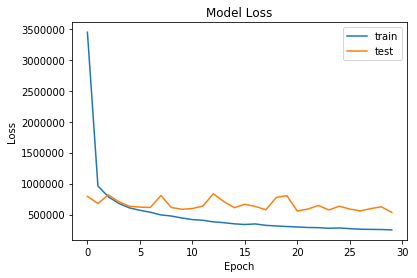

In [13]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()